<a href="https://colab.research.google.com/github/siddhusalvi/Covid-Data-Visualization/blob/Practice/Covid_Data_Visualisation_using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

In [ ]:
!pip install plotly==4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4
import plotly.graph_objects as go

In [19]:
path = '/content/drive/My Drive/Siddhu/data/covidData.json'

In [20]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,DateType
from pyspark.sql.functions import col,when

In [21]:
schema = StructType([
          StructField("agebracket", StringType(), True),
          StructField("backupnotes", StringType(), True),
          StructField("contractedfromwhichpatientsuspected", StringType(), True),
          StructField("currentstatus", StringType(), True),
          StructField("dateannounced", DateType(), True),
          StructField("detectedcity", StringType(), True),
          StructField("detecteddistrict", StringType(), True),
          StructField("detectedstate", StringType(), True),
          StructField("estimatedonsetdate", StringType(), True),
          StructField("gender", StringType(), True),
          StructField("nationality", StringType(), True),
          StructField("notes", StringType(), True),
          StructField("numcases", StringType(), True),
          StructField("patientnumber", StringType(), True),
          StructField("source1", StringType(), True),
          StructField("source2", StringType(), True),
          StructField("source3", StringType(), True),
          StructField("statecode", StringType(), True),
          StructField("statepatientnumber", StringType(), True),
          StructField("statuschangedate", DateType(), True),
          StructField("typeoftransmission", StringType(), True)
])

In [22]:
covidDF = spark.read.option("dateFormat", "dd/MM/yyyy").json(path, schema)

In [23]:
covidDF.count()

28183

In [ ]:
covidDF.show()

In [25]:
covidDF.printSchema

<bound method DataFrame.printSchema of DataFrame[agebracket: string, backupnotes: string, contractedfromwhichpatientsuspected: string, currentstatus: string, dateannounced: date, detectedcity: string, detecteddistrict: string, detectedstate: string, estimatedonsetdate: string, gender: string, nationality: string, notes: string, numcases: string, patientnumber: string, source1: string, source2: string, source3: string, statecode: string, statepatientnumber: string, statuschangedate: date, typeoftransmission: string]>

Affected Gender

In [ ]:
affectedGendersDF = covidDF.where(col("gender") != "")\
.groupby('gender')\
.count()

affectedGendersDF.show()

Affected City

In [27]:
affectedCityDF = covidDF.groupby('detectedcity').count()\
.orderBy(col("count").desc())\
.where(col("detectedcity") != "")

Recoverd patient


In [ ]:
covidDF.filter(col('currentstatus')=='Recovered').groupby('detectedcity').count().orderBy(col("count").desc()).where(col("detectedcity") != "").show()

Affectd Age Group

In [29]:
affectedAgeGroupDF = covidDF.withColumn("age",col("agebracket").cast("Integer"))\
.withColumn("agegroup",when(col("age") < 15,"Minor").when(col("age")< 30,"Young")\
.when(col("age")< 51,"Adult").when(col("age")> 50,"Older"))\
.filter(col('agegroup') != "null" )\
.groupby('agegroup').count()

In [30]:
sc = SparkSession.sparkContext

In [ ]:
!pip install chart_studio

In [54]:
import chart_studio.plotly as py
import plotly.graph_objs as go
import pandas as pd
import requests
requests.packages.urllib3.disable_warnings()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Bar(y=pandasBikeDF.d1))


In [87]:
gender = affectedGendersDF.toPandas()['gender']
count = affectedGendersDF.toPandas()['count']

In [88]:
fig = go.Figure(data=go.Bar(x=gender,y=count))

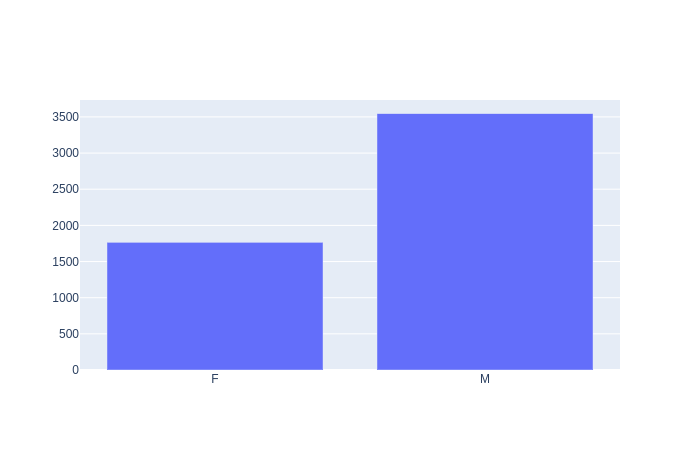

In [90]:
fig.show("png")